# Conditional Self-Attention GAN for Facial Emoji Generation

Adopted from:
- [Coursera Build Basic Generative Adversarial Networks (GANs) Week 4 Programming Assignment: Conditional GAN](https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans/programming/aFndv/conditional-gan)
- [Self-Attention GAN](https://github.com/heykeetae/Self-Attention-GAN)
- [Coursera Build Basic Generative Adversarial Networks (GANs) Week 3 Programming Assignment: WGAN](https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans/programming/mTm3U/wgan)
- [OpenMined](https://blog.openmined.org/differentially-private-deep-learning-using-opacus-in-20-lines-of-code/)

In [1]:
import torch
import os
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from wgan_gp import *
from utils import *

# Parameters

*   image_shape: the number of pixels in each image. We further downsize every image to 64 x 64 to be compatible with the self-attention GAN architecture
*   n_classes: the number of classes (10, since there are 10 different emojis)
*   image_path: path to image folder
*   n_epochs: the number of times to iterate through the entire dataset when training
*   z_dim: the dimension of the noise vector
*   display_step: how often to display/visualize the images
*   batch_size: the number of images per forward/backward pass
*   lr: the learning rate
*   beta_1, beta_2: coefficients used for computing running averages of gradient and its square (used for Adam optimizer)
*   lambda_gp: weight of the gradient penalty
*   device: the device type
*   g_conv_dim: the number of dimensions in the last convolutional layer of the generator
*   d_conv_dim: the number of dimensions in the first convolutional layer of the discriminator
*   ckpt_epoch: how often to save model checkpoint

In [2]:
image_shape = (3, 64, 64)
n_classes = 10
image_path = '../resized_emoji_challenge_128_faces/'
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
lambda_gp = 10
g_conv_dim = 64
d_conv_dim = 64
ckpt_epoch = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
transform = transforms.Compose([
    transforms.Resize((image_shape[1], image_shape[2])),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = ImageFolder(image_path, transform=transform)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

# Initialize generator, discriminator, optimizers

In [4]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, image_shape, n_classes)

gen = Generator(image_shape[1], generator_input_dim, g_conv_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator(discriminator_im_chan, d_conv_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [5]:
print(disc)

Discriminator(
  (l1): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(13, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.2)
  )
  (l2): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (l3): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (l4): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (last): Sequ

# Training

In [37]:
def train(start_epoch, n_epochs, dataloader, gen, gen_opt, disc, disc_opt, save_path):
    cur_step = 0
    generator_losses = []
    discriminator_losses = []

    noise_and_labels = False
    fake = False

    fake_image_and_labels = False
    real_image_and_labels = False
    disc_fake_pred = False
    disc_real_pred = False

    for epoch in range(start_epoch, start_epoch + n_epochs):
        # Dataloader returns the batches and the labels
        for real, labels in tqdm(dataloader):
            for param in disc.parameters(): 
                param.accumulated_grads = []
            cur_batch_size = len(real)
            # Flatten the batch of real images from the dataset
            real = real.to(device)

            one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
            image_one_hot_labels = one_hot_labels[:, :, None, None]
            image_one_hot_labels = image_one_hot_labels.repeat(1, 1, image_shape[1], image_shape[2])

            # Zero out the discriminator gradients
            disc_opt.zero_grad()
            # Get noise corresponding to the current batch_size 
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)

            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
            
            for i in range(cur_batch_size): 
                fake = gen(torch.unsqueeze(noise_and_labels[i], 0))

                fake_image_and_labels = combine_vectors(fake.detach(), torch.unsqueeze(image_one_hot_labels[i], 0))
                real_image_and_labels = combine_vectors(torch.unsqueeze(real[i], 0), torch.unsqueeze(image_one_hot_labels[i], 0))
                disc_fake_pred = disc(fake_image_and_labels)
                disc_real_pred = disc(real_image_and_labels)

                gp = compute_gradient_penalty(disc, torch.unsqueeze(real[i], 0), fake.detach(), torch.unsqueeze(image_one_hot_labels[i], 0), device=device)
                disc_loss = torch.mean(disc_fake_pred) - torch.mean(disc_real_pred) + gp * lambda_gp

                disc_loss.backward(retain_graph=True)
                # disc_opt.step() 

                # Keep track of the average discriminator loss
                discriminator_losses += [disc_loss.item()]

                ### Update generator ###
#                 # Zero out the generator gradients
#                 gen_opt.zero_grad()

                fake_image_and_labels = combine_vectors(fake, torch.unsqueeze(image_one_hot_labels[i], 0))
                disc_fake_pred = disc(fake_image_and_labels)
                gen_loss = -torch.mean(disc_fake_pred)
                gen_loss.backward()
                gen_opt.step()
            
                for param in disc.parameters(): 
                    if param.grad is None: 
                        continue
                    per_sample_grad = param.grad.detach().clone()
                    clip_grad_norm_(per_sample_grad, max_norm=1)
                    param.accumulated_grads.append(per_sample_grad)

                # Keep track of the generator losses
                generator_losses += [gen_loss.item()]
            
            # Aggregate back
            for param in disc.parameters(): 
                if param.grad is None: 
                    continue
                param.grad = torch.stack(param.accumulated_grads, dim=0).sum(dim=0)
                
            for param in disc.parameters(): 
                if param.grad is None or param is None: 
                    continue
                param = param - lr * param.grad
                param += torch.normal(mean=0.5, std=1.5, size=param.shape).to(device)
            
            disc.zero_grad()

            if cur_step % display_step == 0 and cur_step > 0:
                gen_mean = sum(generator_losses[-display_step:]) / display_step
                disc_mean = sum(discriminator_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
                show_tensor_images(fake)
                show_tensor_images(real)
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
                num_examples = (len(generator_losses) // step_bins) * step_bins
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                    label="Generator Loss"
                )
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                    label="Discriminator Loss"
                )
                plt.legend()
                plt.show()
            elif cur_step == 0:
                print("Start training...")
            cur_step += 1
            
        if epoch % ckpt_epoch == 0:
            ckpt_dict = {
                'epoch': epoch,
                'gen_state_dict': gen.state_dict(),
                'gen_opt': gen_opt.state_dict(),
                'disc_state_dict': disc.state_dict(),
                'disc_opt': disc_opt.state_dict(),
            }
            checkpoint_path = os.path.join(save_path, f'epoch_{epoch}.pth.tar')
            torch.save(ckpt_dict, checkpoint_path)

  0%|          | 0/1189 [00:00<?, ?it/s]

Start training...
Step 500: Generator loss: -1.1139812893867493, discriminator loss: 9.897574584960937


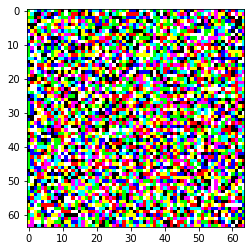

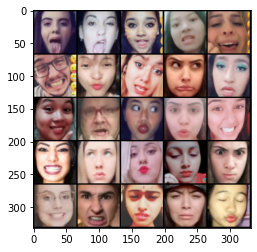

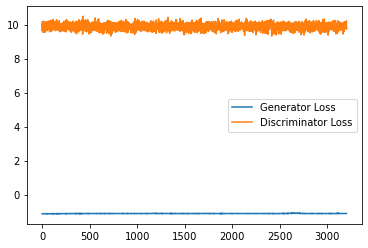

In [ ]:
train(0, n_epochs, dataloader, gen, gen_opt, disc, disc_opt, 'model_ckpt/cSAWGAN-GP-DP')